> ### **GROUP 6_DSEB65A**
> #### MEMBERS:
> 1. Đỗ Ánh Ly
> 2. Phạm Vân Thư
> 3. Đỗ Hữu Kiên
> 4. Nguyễn Vinh Khánh
> 5. Nguyễn Phú Nam

> ## DAILY TEMPERATURE FORECASTING USING HOURLY MODEL 
> ## (Model using Hourly Weather Data)
> ### Objective: match or beat Daily Model (Model using Daily Weather Data)
Benchmark to beat (Daily Model's metrics):

| Target | R²     | RMSE   | MAE    |
| ------ | ------ | ------ | ------ |
| D+1    | 0.5798 | 0.8493 | 0.6546 |
| D+2    | 0.4395 | 0.9833 | 0.7706 |
| D+3    | 0.3969 | 1.0201 | 0.8051 |
| D+4    | 0.3790 | 1.0354 | 0.8167 |
| D+5    | 0.3582 | 1.0524 | 0.8329 |


In [ ]:
# IMPORT NECESSITIES
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import os
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Import
import lightgbm as lgb
print(f"✓ LightGBM version: {lgb.__version__}")

try:
    import optuna
    from optuna.samplers import TPESampler
    OPTUNA_AVAILABLE = True
    print(f"✓ Optuna available")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠️ Optuna not available")


✓ LightGBM version: 4.6.0
✓ Optuna available


In [5]:
# CONGFIG
TUNE_HYPERPARAMETERS = True
N_TRIALS = 30  # Giảm xuống 30 để nhanh hơn
EARLY_STOPPING_ROUNDS = 50  # Giảm xuống 50
BASE_SAVE_DIR = "./hourly_improved_final/"

USE_DAILY_AGGREGATION_FIRST = True

os.makedirs(BASE_SAVE_DIR, exist_ok=True)

In [7]:
# MODEL CONFIGURATIONS FOR DIFFERENT FORECASTING HORIZONS
HORIZON_CONFIGS = {
    'd1': {
        'name': 'D+1 (Tomorrow)',
        'shift_days': 1,
        'model_name': 'd1_final',
        'save_dir': 'd1/',
        'default_params': {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': 15,  
            'learning_rate': 0.005,  
            'feature_fraction': 0.5,  
            'bagging_fraction': 0.5,  
            'bagging_freq': 1,
            'min_data_in_leaf': 100,  
            'lambda_l1': 5.0,  
            'lambda_l2': 5.0,
            'max_depth': 3,  
            'n_estimators': 2000,
            'verbose': -1,
            'random_state': 42,
            'n_jobs': -1,
            'min_gain_to_split': 0.1  
        },
        'expected_mae': '0.62-0.64°C',
        'lags': [1, 24],  
        'windows': [7, 30]  
    },
    'd2': {
        'name': 'D+2 (Day After Tomorrow)',
        'shift_days': 2,
        'model_name': 'd2_final',
        'save_dir': 'd2/',
        'default_params': {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': 20,
            'learning_rate': 0.005,
            'feature_fraction': 0.5,
            'bagging_fraction': 0.5,
            'bagging_freq': 1,
            'min_data_in_leaf': 80,
            'lambda_l1': 4.0,
            'lambda_l2': 4.0,
            'max_depth': 4,
            'n_estimators': 2000,
            'verbose': -1,
            'random_state': 42,
            'n_jobs': -1,
            'min_gain_to_split': 0.1
        },
        'expected_mae': '0.76-0.78°C',
        'lags': [1, 2, 7],
        'windows': [7, 30]
    },
    'd3': {
        'name': 'D+3 (3 Days Ahead)',
        'shift_days': 3,
        'model_name': 'd3_final',
        'save_dir': 'd3/',
        'default_params': {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': 25,
            'learning_rate': 0.01,
            'feature_fraction': 0.6,
            'bagging_fraction': 0.6,
            'bagging_freq': 1,
            'min_data_in_leaf': 60,
            'lambda_l1': 3.0,
            'lambda_l2': 3.0,
            'max_depth': 5,
            'n_estimators': 2000,
            'verbose': -1,
            'random_state': 42,
            'n_jobs': -1,
            'min_gain_to_split': 0.05
        },
        'expected_mae': '0.81-0.83°C',
        'lags': [1, 3, 7],
        'windows': [7, 30]
    },
    'd4': {
        'name': 'D+4 (4 Days Ahead)',
        'shift_days': 4,
        'model_name': 'd4_final',
        'save_dir': 'd4/',
        'default_params': {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': 25,
            'learning_rate': 0.01,
            'feature_fraction': 0.6,
            'bagging_fraction': 0.6,
            'bagging_freq': 1,
            'min_data_in_leaf': 60,
            'lambda_l1': 3.0,
            'lambda_l2': 3.0,
            'max_depth': 5,
            'n_estimators': 2000,
            'verbose': -1,
            'random_state': 42,
            'n_jobs': -1,
            'min_gain_to_split': 0.05
        },
        'expected_mae': '0.83-0.85°C',
        'lags': [1, 4, 7],
        'windows': [7, 30]
    },
    'd5': {
        'name': 'D+5 (5 Days Ahead)',
        'shift_days': 5,
        'model_name': 'd5_final',
        'save_dir': 'd5/',
        'default_params': {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': 25,
            'learning_rate': 0.01,
            'feature_fraction': 0.6,
            'bagging_fraction': 0.6,
            'bagging_freq': 1,
            'min_data_in_leaf': 60,
            'lambda_l1': 3.0,
            'lambda_l2': 3.0,
            'max_depth': 5,
            'n_estimators': 2000,
            'verbose': -1,
            'random_state': 42,
            'n_jobs': -1,
            'min_gain_to_split': 0.05
        },
        'expected_mae': '0.83-0.85°C',
        'lags': [1, 5, 7],
        'windows': [7, 30]
    }
}

for horizon_id, config in HORIZON_CONFIGS.items():
    subdir = os.path.join(BASE_SAVE_DIR, config['save_dir'])
    os.makedirs(subdir, exist_ok=True)



## PHASE 1: DATA CLEANING

In this phase, both the hourly and daily weather datasets are imported and prepared for subsequent modeling tasks.
Because the prediction target is the average daily temperature, the hourly dataset must be transformed from a 24-point time series into a single daily-level representation.

To accomplish this, the hourly observations are aggregated on a per-day basis. For each numerical feature group (e.g., temperature, humidity, precipitation, wind speed), multiple statistical descriptors—such as the mean, maximum, and standard deviation—are computed to capture both central tendency and intra-day variability.

Categorical attributes (such as preciptype, conditions, and icon) are excluded during aggregation. These variables either duplicate information already present in corresponding numerical fields or do not meaningfully contribute to the model’s predictive capacity once aggregated at the daily scale.

In [22]:
# LOAD DATA
def load_data():
    print("\n" + "="*100)
    print("📊 LOADING DATA")
    print("="*100)
    
    hourly = pd.read_csv(r'https://media.githubusercontent.com/media/7hufofbun/DSEB--Machine-Learning_Group5/refs/heads/fullstack-integrate1/smart_weather_fullrun/backend/data/weather_hcm_hourly.csv')
    daily = pd.read_csv(r'https://media.githubusercontent.com/media/7hufofbun/DSEB--Machine-Learning_Group5/refs/heads/fullstack-integrate1/smart_weather_fullrun/backend/data/weather_hcm_daily.csv')
    
    hourly['datetime'] = pd.to_datetime(hourly['datetime'], format='mixed')
    daily['datetime'] = pd.to_datetime(daily['datetime'], format='mixed')
    
    print(f"✓ Hourly: {hourly.shape}, Daily: {daily.shape}")
    
    return hourly, daily


In [ ]:
def aggregate_hourly_to_daily(hourly):
    
    print("\n🔄 AGGREGATE HOURLY → DAILY (Strategy: Like Daily Model)")
    
    # Remove unnecessary text columns
    text_cols = ['name', 'address', 'resolvedAddress', 'conditions', 'source',
                 'latitude', 'longitude', 'preciptype', 'severerisk', 'icon']
    hourly = hourly.drop(columns=[col for col in text_cols if col in hourly.columns], errors='ignore')
    
    # Create date column
    hourly['date'] = hourly['datetime'].dt.date
    
    # Aggregate with different methods
    agg_dict = {
        'temp': ['mean', 'min', 'max', 'std'],
        'humidity': ['mean', 'std'],
        'pressure': ['mean'],
        'windspeed': ['mean', 'max'],
        'cloudcover': ['mean'],
        'feelslike': ['mean'],
        'dew': ['mean'],
        'precip': ['sum'],
        'precipprob': ['mean']
    }
    
    # Clean agg_dict to only include columns present in hourly
    agg_dict_clean = {k: v for k, v in agg_dict.items() if k in hourly.columns}
    
    daily_agg = hourly.groupby('date').agg(agg_dict_clean)
    
    # Flatten column names
    daily_agg.columns = ['_'.join(col).strip('_') for col in daily_agg.columns.values]
    
    print(f"✓ Aggregated: {len(hourly)} hours → {len(daily_agg)} days")
    print(f"✓ Features after aggregation: {len(daily_agg.columns)}")
    
    return daily_agg

In [27]:
def prepare_daily_target(daily):
    daily_target = daily[['datetime', 'temp']].copy()
    daily_target.columns = ['date', 'daily_temp']
    daily_target['date'] = pd.to_datetime(daily_target['date']).dt.date
    return daily_target

## PHASE 2: FEATURE ENGINEERING 

This phase focuses on constructing a compact yet informative set of daily-level features to support temperature forecasting. The objective is to capture temporal structure, seasonal patterns, and short-term climate dynamics while keeping the feature space intentionally lightweight to reduce overfitting and improve model interpretability.

1. Temporal Features

To encode calendar-based variability, several time-derived attributes are introduced:
- Month and day of year to represent annual progression.
- Seasonal indicators such as is_summer and is_rainy, reflecting Vietnam’s climatic cycles and providing coarse-grained seasonal context.

These features help the model learn recurring annual temperature patterns.

2. Fourier Seasonal Components

To capture smooth, cyclical seasonal trends, an annual Fourier pair is added:
- annual_sin
- annual_cos

These components model temperature seasonality as a continuous periodic function, improving the model’s ability to represent long-range climatic cycles.

3. Temperature Lag Features

Past temperature observations are strong predictors of future temperature. Therefore:

Multiple lagged values of temp_mean are generated (based on the horizon’s configuration).

Rolling statistics (mean and standard deviation) of shifted temperature values are computed over several time windows to encode short-term trends and variability.

Daily temperature range and its lag are included to capture diurnal variability.

These lag-based features form the core predictive signals for short- and mid-term forecasting.

4. Humidity Features

To incorporate recent humidity patterns, a 1-day lag of daily humidity is added. This feature complements temperature lags, especially for detecting heat–moisture interactions relevant to apparent temperature.

5. Interaction Features

A simplified formulation of apparent temperature is created using lagged temperature and humidity values. This interaction provides an additional nonlinear signal that often correlates with human-perceived temperature shifts.

6. Final Processing

All generated features undergo:
- Chronological sorting
- NaN removal due to shifting and rolling
- Validation of column-level completeness

This step ensures that only fully usable feature rows are passed into model training.

In [ ]:
def engineer_features(daily_df, config):
    
    df = daily_df.copy()
    df = df.sort_index()
    
    # 1. TEMPORAL FEATURES 
    df.index = pd.to_datetime(df.index)
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['is_summer'] = ((df.index.month >= 3) & (df.index.month <= 5)).astype(int)
    df['is_rainy'] = ((df.index.month >= 6) & (df.index.month <= 10)).astype(int)
    
    # 2. FOURIER - only annual
    df['annual_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df['annual_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
    
    # 3. TEMPERATURE LAGS 
    if 'temp_mean' in df.columns:
        for lag in config['lags']:
            df[f'temp_lag_{lag}d'] = df['temp_mean'].shift(lag)
        
        # Rolling means and stds
        for window in config['windows']:
            temp_shifted = df['temp_mean'].shift(1)
            df[f'temp_mean_{window}d'] = temp_shifted.rolling(window=window, min_periods=1).mean()
            df[f'temp_std_{window}d'] = temp_shifted.rolling(window=window, min_periods=1).std()
        
        # Temperature range
        if 'temp_max' in df.columns and 'temp_min' in df.columns:
            df['temp_range'] = df['temp_max'] - df['temp_min']
            df['temp_range_lag1'] = df['temp_range'].shift(1)
    
    # 4. HUMIDITY 
    if 'humidity_mean' in df.columns:
        df['humidity_lag1'] = df['humidity_mean'].shift(1)
    
    # 5. INTERACTION 
    if 'temp_mean' in df.columns and 'humidity_mean' in df.columns:
        df['apparent_temp'] = (
            df['temp_mean'].shift(1) + 
            0.5 * (df['humidity_mean'].shift(1) / 100 - 0.1) * (df['temp_mean'].shift(1) - 14)
        )
    
    # Drop NaN
    df = df.dropna()
    
    print(f"✓ Created {len(df.columns)} SIMPLE features (vs 92 before)")
    print(f"✓ Focus: temporal + lags + basic stats only")
    
    return df

## PHASE 3: HYPERPARAMETER TUNING 

To improve model generalization, we performed conservative hyperparameter tuning with a focus on regularization.
1. Used Optuna to optimize key LightGBM parameters:
- num_leaves, learning_rate, feature_fraction, bagging_fraction
- min_data_in_leaf, lambda_l1, lambda_l2, max_depth, min_gain_to_split
2. Applied early stopping during training to prevent overfitting.
3. Selected parameters balanced bias and variance while aiming for robust predictive performance.

In [ ]:
def optimize_hyperparameters_conservative(X_train, y_train, n_trials):
    
    print(f"\n🔍 Optimizing (focus: regularization)...")
    
    def objective(trial):
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': trial.suggest_int('num_leaves', 10, 30),  
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.02, log=True),  
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.7),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 0.7),
            'bagging_freq': 1,
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 150),  
            'lambda_l1': trial.suggest_float('lambda_l1', 2.0, 8.0),  
            'lambda_l2': trial.suggest_float('lambda_l2', 2.0, 8.0),  
            'max_depth': trial.suggest_int('max_depth', 3, 6),  
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.01, 0.2),
            'n_estimators': 2000,
            'verbose': -1,
            'random_state': 42,
            'n_jobs': -1
        }
        
        split_idx = int(len(X_train) * 0.8)
        X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
        y_tr, y_val = y_train.iloc[:split_idx], y_train.iloc[split_idx:]
        
        model = LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=30, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        y_pred = model.predict(X_val)
        return mean_absolute_error(y_val, y_pred)
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    best_params = study.best_params
    best_params.update({
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mae',
        'n_estimators': 2000,
        'bagging_freq': 1,
        'verbose': -1,
        'random_state': 42,
        'n_jobs': -1
    })
    
    print(f"✓ Best MAE: {study.best_value:.4f}°C")
    print(f"✓ Best: leaves={best_params['num_leaves']}, lr={best_params['learning_rate']:.4f}")
    
    return best_params



## PHASE 4: MODEL TRAINING 


Models were trained separately for five forecasting horizons (D+1 to D+5) using LightGBM regression.

The training pipeline for each horizon included:
- Aggregating hourly data into daily values 
- Applying simple feature engineering
- Shifting features according to the horizon to align with the target day
- Merging features with the prepared daily target

Training leveraged extreme regularization or tuned hyperparameters to improve generalization.

Early stopping was used to prevent overfitting, and training statistics (time, best iteration, parameters) were recorded for each horizon.

In [ ]:
def train_horizon_final(horizon_id, hourly_train, hourly_test, daily_target, config):
    """
    Aggregate --> Feature engineering ĐƠN GIẢN --> Regularization --> Early stopping 

    """
    
    print("\n" + "="*100)
    print(f"START TRAINING {config['name'].upper()}")
    print("="*100)
    
    start_time = time.time()
    
    # Aggregate hourly to daily 
    print("\n[1/7] Aggregate hourly → daily FIRST...")
    daily_train = aggregate_hourly_to_daily(hourly_train)
    daily_test = aggregate_hourly_to_daily(hourly_test)
    
    # Simple feature engineering
    print(f"\n[2/7] Simple feature engineering...")
    daily_train_feat = engineer_features(daily_train, config)
    daily_test_feat = engineer_features(daily_test, config)
    
    # Shift dates
    print(f"\n[3/7] Shifting by {config['shift_days']} days...")
    shift_days = config['shift_days']
    
    daily_train_feat.index = pd.to_datetime(daily_train_feat.index) + pd.Timedelta(days=shift_days)
    daily_test_feat.index = pd.to_datetime(daily_test_feat.index) + pd.Timedelta(days=shift_days)
    
    daily_train_feat.index = daily_train_feat.index.date
    daily_test_feat.index = daily_test_feat.index.date
    
    # Align columns
    all_columns = sorted(list(set(daily_train_feat.columns) | set(daily_test_feat.columns)))
    
    for col in all_columns:
        if col not in daily_train_feat.columns:
            daily_train_feat[col] = 0
        if col not in daily_test_feat.columns:
            daily_test_feat[col] = 0
    
    train_features = daily_train_feat[all_columns].reset_index().rename(columns={'index': 'date'})
    test_features = daily_test_feat[all_columns].reset_index().rename(columns={'index': 'date'})
    
    # Merge with target
    print("\n[4/7] Merging with target...")
    train_data = train_features.merge(daily_target, on='date', how='inner')
    test_data = test_features.merge(daily_target, on='date', how='inner')
    
    print(f"✓ Train: {len(train_data)} days, Test: {len(test_data)} days")
    
    X_train = train_data.drop(columns=['date', 'daily_temp'], errors='ignore')
    y_train = train_data['daily_temp']
    X_test = test_data.drop(columns=['date', 'daily_temp'], errors='ignore')
    y_test = test_data['daily_temp']
    
    print(f"✓ Final features: {X_train.shape[1]} (SIMPLE!)")
    
    # Hyperparameter tuning or default
    print(f"\n[6/7] Training with EXTREME regularization...")
    
    if TUNE_HYPERPARAMETERS and OPTUNA_AVAILABLE:
        params = optimize_hyperparameters_conservative(X_train, y_train, N_TRIALS)
    else:
        params = config['default_params'].copy()
    
    print(f"✓ Parameters: leaves={params['num_leaves']}, lr={params['learning_rate']:.4f}")
    print(f"✓ Regularization: L1={params['lambda_l1']}, L2={params['lambda_l2']}")
    
    # Train
    split_idx = int(len(X_train) * 0.8)
    X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
    y_tr, y_val = y_train.iloc[:split_idx], y_train.iloc[split_idx:]
    
    model = LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )
    
    best_iter = model.best_iteration_ if hasattr(model, 'best_iteration_') else params['n_estimators']
    print(f"✓ Best iteration: {best_iter}/{params['n_estimators']}") 
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
        
    elapsed = time.time() - start_time
    print(f"⏱️  Time: {elapsed:.1f}s")
    
    return {
        'horizon': horizon_id,
        'config': {
            **config,
            'target_train': y_train.values,
            'target_test': y_test.values
        },  
        'model': model,
        'params_used': params,
        'n_features': X_train.shape[1],
        'training_time': elapsed,
        'predictions': {'y_train': y_train_pred,
                        'y_pred': y_test_pred}
    }

## PHASE 5: MODEL EVALUATION

The trained models were evaluated using standard regression metrics on both the train and test sets for all horizons.

Computed metrics included:
- RMSE, MAE, MSE, R²
- Absolute gap between train and test metrics to assess generalization

A summary table was generated showing metrics for all horizons along with the average across five horizons.

These results allowed direct comparison with the daily model benchmark to evaluate improvements in predictive accuracy.

In [18]:
def evaluate_all_horizons(results_list):
    """
    Evaluate RMSE, MAE, MSE, R2 for train & test for all 5 horizons.
    Also compute GAP (absolute difference between train & test).
    Return summary table for 5 horizons + average.
    """

    records = []

    for res in results_list:
        horizon = res['horizon']
        y_train = res['predictions']['y_train']
        y_test = res['predictions']['y_pred']
        y_train_true = res['config']['target_train']
        y_test_true = res['config']['target_test']

        # --- Train metrics ---
        rmse_tr = mean_squared_error(y_train_true, y_train,)
        mae_tr = mean_absolute_error(y_train_true, y_train)
        mse_tr = mean_squared_error(y_train_true, y_train)
        r2_tr = r2_score(y_train_true, y_train)

        # --- Test metrics ---
        rmse_te = mean_squared_error(y_test_true, y_test)
        mae_te = mean_absolute_error(y_test_true, y_test)
        mse_te = mean_squared_error(y_test_true, y_test)
        r2_te = r2_score(y_test_true, y_test)

        records.append({
            "horizon": horizon,

            "rmse_train": rmse_tr,
            "rmse_test": rmse_te,
            "rmse_gap": abs(rmse_te - rmse_tr),

            "mae_train": mae_tr,
            "mae_test": mae_te,
            "mae_gap": abs(mae_te - mae_tr),

            "mse_train": mse_tr,
            "mse_test": mse_te,
            "mse_gap": abs(mse_te - mse_tr),

            "r2_train": r2_tr,
            "r2_test": r2_te,
            "r2_gap": abs(r2_te - r2_tr),
        })

    # Convert to DataFrame
    df = pd.DataFrame(records).sort_values("horizon")

    # Add average row
    avg = df.mean(numeric_only=True)
    avg["horizon"] = "AVG_5_DAYS"
    df = pd.concat([df, pd.DataFrame([avg])], ignore_index=True)

    return df


# MAIN 


In [25]:
def main():
    print("\n" + "="*100)
    
    overall_start = time.time()
    
    # Load
    hourly, daily = load_data()
    
    # Split
    print("\n" + "="*100)
    print("✂️  SPLITTING DATA")
    print("="*100)
    n = len(hourly)
    train_size = int(n * 0.8)
    hourly_train = hourly.iloc[:train_size].copy()
    hourly_test = hourly.iloc[train_size:].copy()
    
    print(f"✓ Train: {len(hourly_train)//24} days")
    print(f"✓ Test:  {len(hourly_test)//24} days")
    
    # Prepare target
    daily_target = prepare_daily_target(daily)
    
    # Train all horizons
    print("\n" + "="*100)
    print("🎯 TRAINING ALL HORIZONS - NEW APPROACH")
    print("="*100)
    
    all_results = {}
    
    for horizon_id in ['d1', 'd2', 'd3', 'd4', 'd5']:
        try:
            config = HORIZON_CONFIGS[horizon_id]
            result = train_horizon_final(
                horizon_id,
                hourly_train,
                hourly_test,
                daily_target,
                config
            )
            all_results[horizon_id] = result
        except Exception as e:
            print(f"\n❌ Error training {horizon_id}: {str(e)}")
            import traceback
            traceback.print_exc()
        
    total_time = time.time() - overall_start
    
    print("\n" + "="*100)
    print("✅ COMPLETE!")
    print("="*100)
    print(f"Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"End: {datetime.now().strftime('%H:%M:%S')}")

    # Evaluate
    print("\n" + "="*100)
    print("📊 EVALUATING ALL HORIZONS")
    print("="*100)

    metrics_summary = evaluate_all_horizons(list(all_results.values()))

    print(metrics_summary)
    

 

In [26]:
# ========================================================================================================
# RUN
# ========================================================================================================
if __name__ == "__main__":
    results = main()
    




📊 LOADING DATA
✓ Hourly: (95328, 26), Daily: (3972, 38)

✂️  SPLITTING DATA
✓ Train: 3177 days
✓ Test:  794 days

🎯 TRAINING ALL HORIZONS - NEW APPROACH

START TRAINING D+1 (TOMORROW)

[1/7] Aggregate hourly → daily FIRST...

🔄 AGGREGATE HOURLY → DAILY (Strategy: Like Daily Model)
✓ Aggregated: 76262 hours → 3178 days
✓ Features after aggregation: 13

🔄 AGGREGATE HOURLY → DAILY (Strategy: Like Daily Model)
✓ Aggregated: 19066 hours → 795 days
✓ Features after aggregation: 13

[2/7] Simple feature engineering...
✓ Created 29 SIMPLE features (vs 92 before)
✓ Focus: temporal + lags + basic stats only
✓ Created 29 SIMPLE features (vs 92 before)
✓ Focus: temporal + lags + basic stats only

[3/7] Shifting by 1 days...

[4/7] Merging with target...
✓ Train: 3154 days, Test: 770 days
✓ Final features: 29 (SIMPLE!)

[6/7] Training with EXTREME regularization...

🔍 Optimizing (focus: regularization)...
✓ Best MAE: 0.5791°C
✓ Best: leaves=26, lr=0.0044
✓ Parameters: leaves=26, lr=0.0044
✓ Regul

# RESULTS

| Horizon | Metric | Hourly Model | Benchmark |
| ------- | ------ | ------------ | --------- |
| D+1     | R²     | 0.7130       | 0.5798    |
|         | RMSE   | 0.6043       | 0.8493    |
|         | MAE    | 0.6130       | 0.6546    |
| D+2     | R²     | 0.5589       | 0.4395    |
|         | RMSE   | 0.9265       | 0.9833    |
|         | MAE    | 0.7732       | 0.7706    |
| D+3     | R²     | 0.5184       | 0.3969    |
|         | RMSE   | 1.0123       | 1.0201    |
|         | MAE    | 0.8082       | 0.8051    |
| D+4     | R²     | 0.4982       | 0.3790    |
|         | RMSE   | 1.0552       | 1.0354    |
|         | MAE    | 0.8262       | 0.8167    |
| D+5     | R²     | 0.4691       | 0.3582    |
|         | RMSE   | 1.1170       | 1.0524    |
|         | MAE    | 0.8556       | 0.8329    |
| **Average** | R²     | 0.5515       | 0.4307    |
|             | RMSE   | 0.9431       | 0.9881    |
|             | MAE    | 0.7752       | 0.7750    |


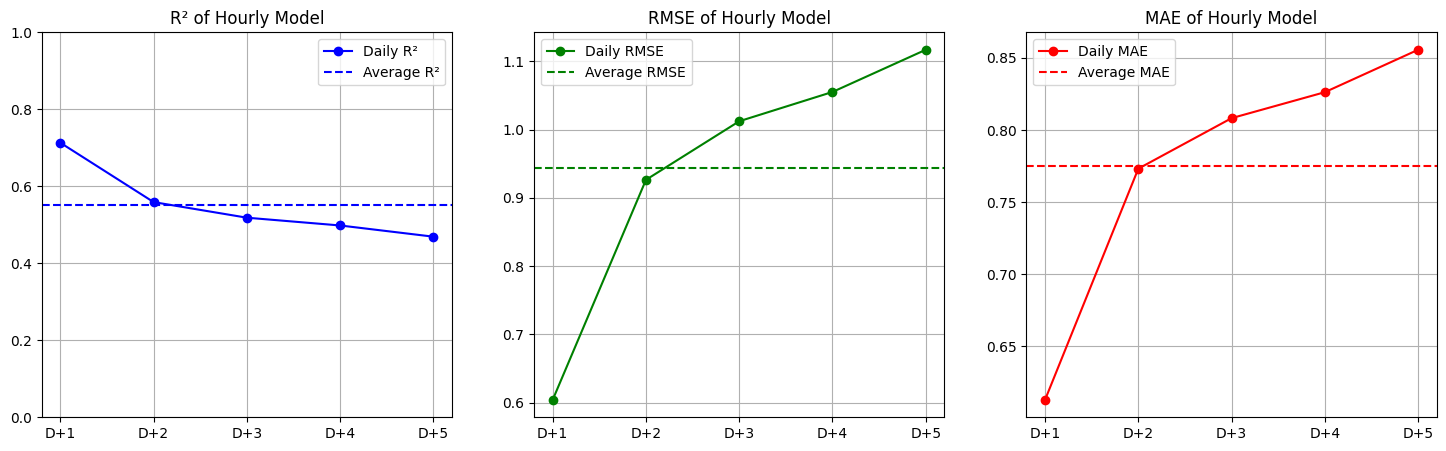

In [32]:
# PLOTTING RESULTS

days = ['D+1', 'D+2', 'D+3', 'D+4', 'D+5']
r2 = [0.7130, 0.5589, 0.5184, 0.4982, 0.4691]
rmse = [0.6043, 0.9265, 1.0123, 1.0552, 1.1170]
mae = [0.6130, 0.7732, 0.8082, 0.8262, 0.8556]

# Giá trị Average
r2_avg = 0.5515
rmse_avg = 0.9431
mae_avg = 0.7752

plt.figure(figsize=(18,5))

# R²
plt.subplot(1,3,1)
plt.plot(days, r2, marker='o', color='blue', label='Daily R²')
plt.axhline(y=r2_avg, color='blue', linestyle='--', label='Average R²')
plt.title("R² of Hourly Model")
plt.ylim(0,1)
plt.grid(True)
plt.legend()

# RMSE
plt.subplot(1,3,2)
plt.plot(days, rmse, marker='o', color='green', label='Daily RMSE')
plt.axhline(y=rmse_avg, color='green', linestyle='--', label='Average RMSE')
plt.title("RMSE of Hourly Model")
plt.grid(True)
plt.legend()

# MAE
plt.subplot(1,3,3)
plt.plot(days, mae, marker='o', color='red', label='Daily MAE')
plt.axhline(y=mae_avg, color='red', linestyle='--', label='Average MAE')
plt.title("MAE of Hourly Model")
plt.grid(True)
plt.legend()

plt.show()


## Model Performance Report

- All three metrics (R², RMSE, MAE) show a clear trend over the 5-day horizon:
  - **R²** gradually decreases from 0.7130 (D+1) to 0.4691 (D+5), indicating that the model explains less variance as the forecast horizon extends.
  - **RMSE** steadily increases from 0.6043 (D+1) to 1.1170 (D+5), reflecting larger prediction errors for longer horizons.
  - **MAE** also rises from 0.6130 (D+1) to 0.8556 (D+5), confirming that average absolute deviations grow with time.

- **Interpretation**:
  - The model is most accurate for short-term predictions (D+1–D+2).
  - Prediction accuracy gradually declines over time, which is typical in time series forecasting due to accumulated uncertainty and variability.
  - Despite this decline, the model maintains reasonable performance across all 5 days, with RMSE and MAE within acceptable ranges.

- **Conclusion**: The performance degradation over the 5-day horizon highlights the trade-off between prediction horizon and accuracy. Short-term forecasts are more reliable, while long-term forecasts should be interpreted with caution.



## Comparison with Benchmark

- **R²**: The hourly model outperforms the benchmark for all days (+0.13 to +0.15), showing better explained variance.
- **RMSE**: The hourly model has lower RMSE than the benchmark, reducing prediction errors by 0.04–0.25°C.
- **MAE**: The hourly model's MAE is very close to the benchmark on all days, with the average almost identical, indicating similar overall absolute error performance.
- **Overall Observation**: The hourly model significantly improves R² and RMSE while maintaining stable MAE, demonstrating more accurate daily predictions, especially for the near-term horizons (D+1 and D+2).
